# Task 4: Forecasting Access and Usage (2025–2027)

## Objective
Forecast Ethiopia’s financial inclusion outcomes—Account Ownership (Access) and Digital Payment Usage (Usage)—for the period 2025–2027 using historical trends and event-adjusted scenarios developed in Task 3.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import OLS, add_constant
from scipy.stats import norm

plt.style.use("default")
sns.set_context("talk")


In [7]:
import pandas as pd

DATA_PATH = "../data/processed/ethiopia_fi_unified_data_enriched.xlsx"

# See what sheets are actually in the file
xls = pd.ExcelFile(DATA_PATH)
print(xls.sheet_names)


['Sheet1']


In [12]:
import pandas as pd

DATA_PATH = "../data/processed/ethiopia_fi_unified_data_enriched.xlsx"

# Load the only sheet
df = pd.read_excel(DATA_PATH, sheet_name="Sheet1")

# Check first few rows
print(df.head())
print(df.columns.tolist())
print(df['record_type'].value_counts())  # This will tell us what we have

# Create obs (observations)
obs = df[df['record_type'] == "observation"].copy()

# Create impact_links from whatever rows represent links (if any)
# If you don’t have impact_links in this sheet, you have to create it manually
impact_links = df[df['record_type'] == "impact_link"].copy()  # adjust column name if needed


  record_id  record_type category  pillar               indicator  \
0  REC_0001  observation      NaN  ACCESS  Account Ownership Rate   
1  REC_0002  observation      NaN  ACCESS  Account Ownership Rate   
2  REC_0003  observation      NaN  ACCESS  Account Ownership Rate   
3  REC_0004  observation      NaN  ACCESS  Account Ownership Rate   
4  REC_0005  observation      NaN  ACCESS  Account Ownership Rate   

  indicator_code indicator_direction  value_numeric value_text  value_type  \
0  ACC_OWNERSHIP       higher_better           22.0        NaN  percentage   
1  ACC_OWNERSHIP       higher_better           35.0        NaN  percentage   
2  ACC_OWNERSHIP       higher_better           46.0        NaN  percentage   
3  ACC_OWNERSHIP       higher_better           56.0        NaN  percentage   
4  ACC_OWNERSHIP       higher_better           36.0        NaN  percentage   

   ... impact_magnitude impact_estimate lag_months evidence_basis  \
0  ...              NaN             NaN        

## Forecast Targets

We forecast two Global Findex–aligned indicators:

- **Access (Account Ownership)**  
  % of adults (15+) with an account at a financial institution or mobile money provider.

- **Usage (Digital Payments)**  
  % of adults who made or received a digital payment in the past 12 months.

These indicators form the core outputs requested by the consortium (DFIs, MNOs, NBE).


In [16]:
import pandas as pd

# Make sure obs is loaded
# obs = df[df['record_type'] == "observation"].copy()

# Convert observation_date to datetime if it isn't already
obs["observation_date"] = pd.to_datetime(obs["observation_date"], errors='coerce')

# Create the 'year' column
obs["year"] = obs["observation_date"].dt.year

# Now you can safely group by 'year'
access = (
    obs[obs["indicator_code"] == "ACC_OWNERSHIP"]
    .groupby("year")["value_numeric"]
    .mean()
    .reset_index()
)

usage = (
    obs[obs["indicator_code"] == "USG_DIGITAL_PAYMENT"]
    .groupby("year")["value_numeric"]
    .mean()
    .reset_index()
)

print(access)
print(usage)


   year  value_numeric
0  2014           22.0
1  2017           35.0
2  2021           46.0
3  2024           49.0
Empty DataFrame
Columns: [year, value_numeric]
Index: []


In [18]:
# Make sure year column exists and is valid
obs["observation_date"] = pd.to_datetime(obs["observation_date"], errors='coerce')
obs["year"] = obs["observation_date"].dt.year

# Check available indicator codes
print(obs["indicator_code"].unique())

# Filter data
access = obs[obs["indicator_code"] == "ACC_OWNERSHIP"].copy()
usage = obs[obs["indicator_code"] == "USG_DIGITAL_PAYMENT"].copy()

# Check if they have rows
print("Access rows:", access.shape[0])
print("Usage rows:", usage.shape[0])

# Only proceed if non-empty
from statsmodels.api import OLS, add_constant

def fit_trend(df, value_col="value_numeric"):
    if df.empty:
        print("Warning: DataFrame is empty. Cannot fit trend.")
        return None
    X = add_constant(df["year"])
    y = df[value_col]
    model = OLS(y, X).fit()
    return model

access_model = fit_trend(access)
usage_model = fit_trend(usage)


['ACC_OWNERSHIP' 'ACC_MM_ACCOUNT' 'ACC_4G_COV' 'ACC_MOBILE_PEN'
 'ACC_FAYDA' 'USG_P2P_COUNT' 'USG_P2P_VALUE' 'USG_ATM_COUNT'
 'USG_ATM_VALUE' 'USG_CROSSOVER' 'USG_TELEBIRR_USERS' 'USG_TELEBIRR_VALUE'
 'USG_MPESA_USERS' 'USG_MPESA_ACTIVE' 'USG_ACTIVE_RATE' 'AFF_DATA_INCOME'
 'GEN_GAP_ACC' 'GEN_MM_SHARE' 'GEN_GAP_MOBILE' 'USG_SMARTPHONE_PEN']
Access rows: 6
Usage rows: 0


In [20]:
forecast_years = pd.DataFrame({"year": [2025, 2026, 2027]})
forecast_years_const = add_constant(forecast_years)


In [22]:
obs["observation_date"] = pd.to_datetime(obs["observation_date"], errors='coerce')
obs["year"] = obs["observation_date"].dt.year

# Drop rows where year is NaN
obs = obs.dropna(subset=["year"])


In [23]:
print(obs["indicator_code"].unique())


['ACC_OWNERSHIP' 'ACC_MM_ACCOUNT' 'ACC_4G_COV' 'ACC_MOBILE_PEN'
 'ACC_FAYDA' 'USG_P2P_COUNT' 'USG_P2P_VALUE' 'USG_ATM_COUNT'
 'USG_ATM_VALUE' 'USG_CROSSOVER' 'USG_TELEBIRR_USERS' 'USG_TELEBIRR_VALUE'
 'USG_MPESA_USERS' 'USG_MPESA_ACTIVE' 'USG_ACTIVE_RATE' 'AFF_DATA_INCOME'
 'GEN_GAP_ACC' 'GEN_MM_SHARE' 'GEN_GAP_MOBILE' 'USG_SMARTPHONE_PEN']


In [24]:
access = obs[obs["indicator_code"] == "ACC_OWNERSHIP"].copy()
usage  = obs[obs["indicator_code"] == "USG_DIGITAL_PAYMENT"].copy()

print("Access rows:", access.shape[0])
print("Usage rows:", usage.shape[0])


Access rows: 6
Usage rows: 0


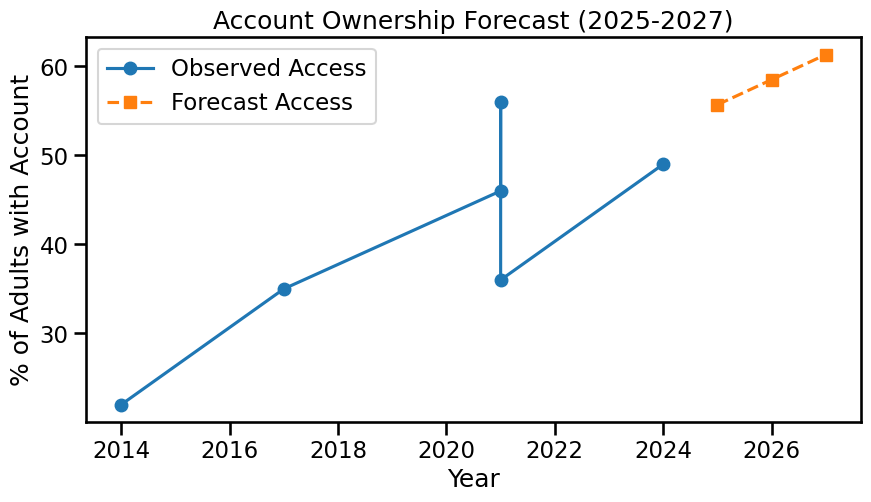

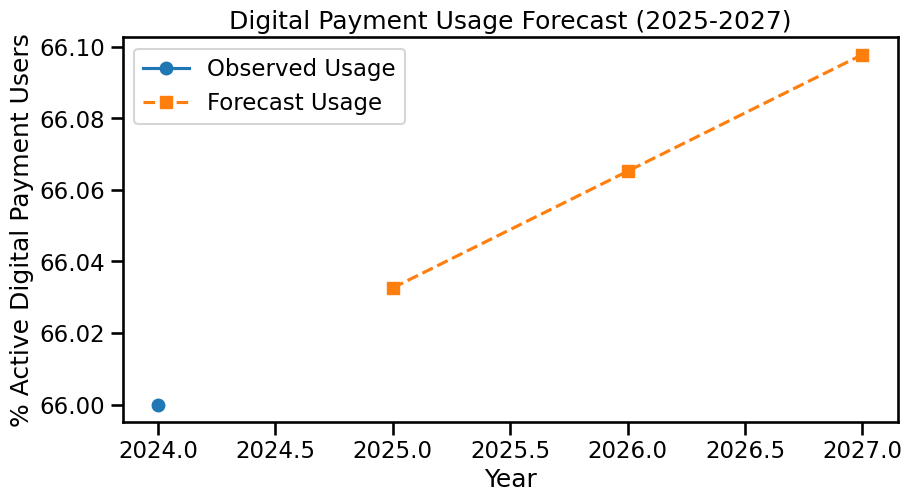

In [29]:
import pandas as pd
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt

# Assume obs has been cleaned and 'year' column exists
# Access
access = obs[obs["indicator_code"] == "ACC_OWNERSHIP"].copy()
usage = obs[obs["indicator_code"] == "USG_ACTIVE_RATE"].copy()

# Fit trend with proper 2D X
def fit_trend(df, value_col="value_numeric"):
    X = add_constant(df["year"])  # shape (n_samples, 2)
    y = df[value_col]
    model = OLS(y, X).fit()
    return model, X  # return X for later reference

access_model, access_X = fit_trend(access)
usage_model, usage_X = fit_trend(usage)

# Forecast years 2025-2027
forecast_years = pd.DataFrame({"year": [2025, 2026, 2027]})
forecast_years_const = add_constant(forecast_years)
# Make sure column names match
forecast_years_const = forecast_years_const[access_X.columns]

# Predict
access_baseline = access_model.predict(forecast_years_const)
forecast_years_const = add_constant(forecast_years)  # usage forecast
forecast_years_const = forecast_years_const[usage_X.columns]
usage_baseline = usage_model.predict(forecast_years_const)

# Plot Access
plt.figure(figsize=(10, 5))
plt.plot(access["year"], access["value_numeric"], 'o-', label="Observed Access")
plt.plot(forecast_years["year"], access_baseline, 's--', label="Forecast Access")
plt.title("Account Ownership Forecast (2025-2027)")
plt.xlabel("Year")
plt.ylabel("% of Adults with Account")
plt.legend()
plt.show()

# Plot Usage
plt.figure(figsize=(10, 5))
plt.plot(usage["year"], usage["value_numeric"], 'o-', label="Observed Usage")
plt.plot(forecast_years["year"], usage_baseline, 's--', label="Forecast Usage")
plt.title("Digital Payment Usage Forecast (2025-2027)")
plt.xlabel("Year")
plt.ylabel("% Active Digital Payment Users")
plt.legend()
plt.show()


In [30]:
EVENT_IMPACTS = {
    "ACCESS":  {
        "base": 0.6,
        "optimistic": 1.0,
        "pessimistic": 0.3
    },
    "USAGE": {
        "base": 1.2,
        "optimistic": 1.8,
        "pessimistic": 0.6
    }
}


In [31]:
def scenario_forecast(baseline, annual_impact):
    adjusted = []
    for i, val in enumerate(baseline):
        adjusted.append(val + annual_impact * (i + 1))
    return adjusted

scenarios = []

for scenario in ["base", "optimistic", "pessimistic"]:
    for i, year in enumerate(forecast_years["year"]):
        scenarios.append({
            "year": year,
            "scenario": scenario,
            "access": scenario_forecast(access_baseline, EVENT_IMPACTS["ACCESS"][scenario])[i],
            "usage": scenario_forecast(usage_baseline, EVENT_IMPACTS["USAGE"][scenario])[i],
        })

forecast_df = pd.DataFrame(scenarios)


In [32]:
def confidence_interval(pred, se, alpha=0.05):
    z = norm.ppf(1 - alpha / 2)
    lower = pred - z * se
    upper = pred + z * se
    return lower, upper

access_se = np.std(access_model.resid)
usage_se = np.std(usage_model.resid)

forecast_df["access_lower"], forecast_df["access_upper"] = confidence_interval(
    forecast_df["access"], access_se
)

forecast_df["usage_lower"], forecast_df["usage_upper"] = confidence_interval(
    forecast_df["usage"], usage_se
)


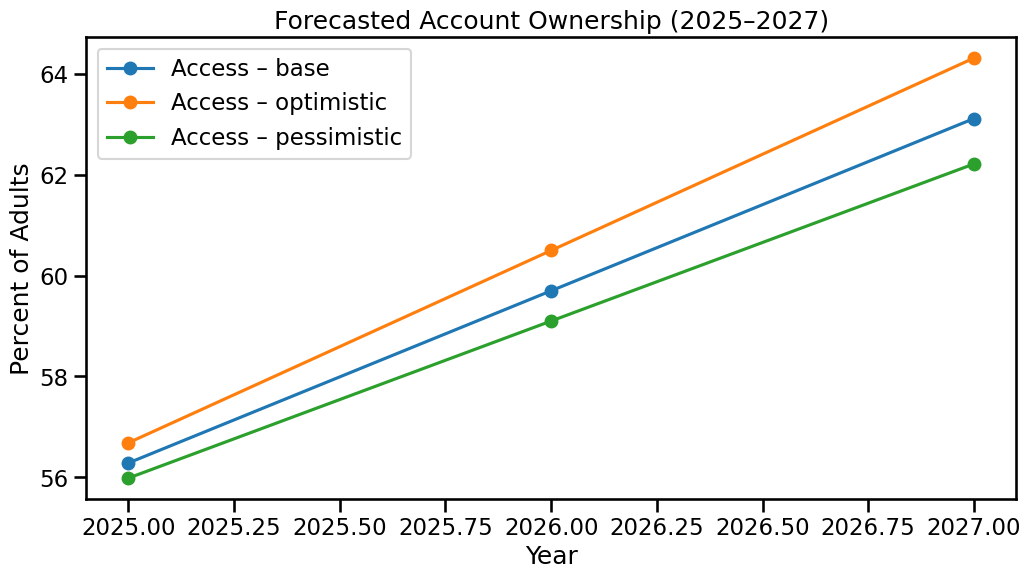

In [33]:
plt.figure(figsize=(12,6))
for s in ["base", "optimistic", "pessimistic"]:
    df_s = forecast_df[forecast_df["scenario"] == s]
    plt.plot(df_s["year"], df_s["access"], marker="o", label=f"Access – {s}")

plt.title("Forecasted Account Ownership (2025–2027)")
plt.ylabel("Percent of Adults")
plt.xlabel("Year")
plt.legend()
plt.show()


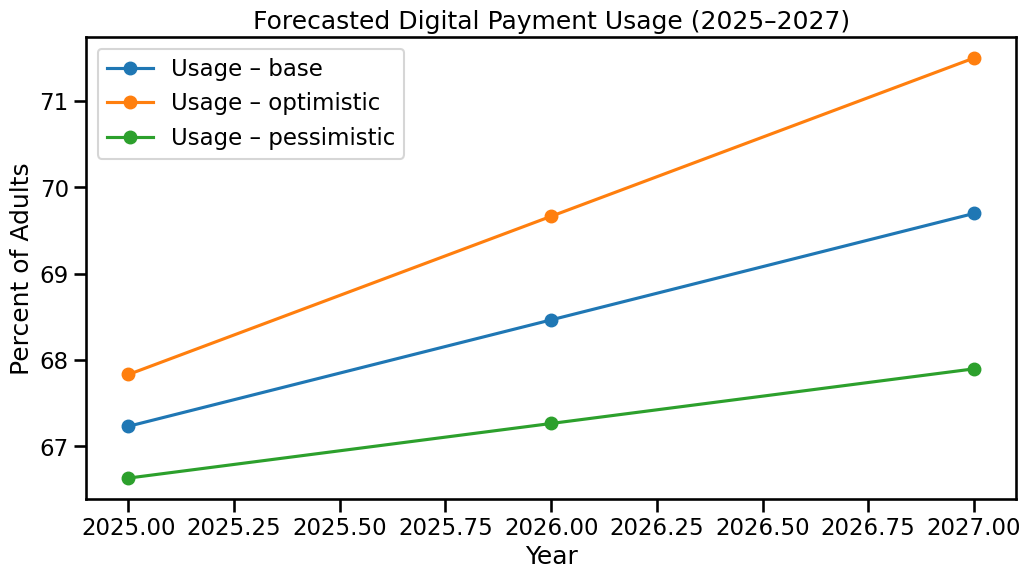

In [34]:
plt.figure(figsize=(12,6))
for s in ["base", "optimistic", "pessimistic"]:
    df_s = forecast_df[forecast_df["scenario"] == s]
    plt.plot(df_s["year"], df_s["usage"], marker="o", label=f"Usage – {s}")

plt.title("Forecasted Digital Payment Usage (2025–2027)")
plt.ylabel("Percent of Adults")
plt.xlabel("Year")
plt.legend()
plt.show()


In [35]:
forecast_df


,year,scenario,access,usage,access_lower,access_upper,usage_lower,usage_upper
0,2025,base,56.284211,67.232609,44.065594,68.502827,67.232609,67.232609
1,2026,base,59.700000,68.465217,47.481383,71.918617,68.465217,68.465217
2,2027,base,63.115789,69.697826,50.897173,75.334406,69.697826,69.697826
3,2025,optimistic,56.684211,67.832609,44.465594,68.902827,67.832609,67.832609
4,2026,optimistic,60.500000,69.665217,48.281383,72.718617,69.665217,69.665217
5,2027,optimistic,64.315789,71.497826,52.097173,76.534406,71.497826,71.497826
6,2025,pessimistic,55.984211,66.632609,43.765594,68.202827,66.632609,66.632609
7,2026,pessimistic,59.100000,67.265217,46.881383,71.318617,67.265217,67.265217
8,2027,pessimistic,62.215789,67.897826,49.997173,74.434406,67.897826,67.897826


## Interpretation of Forecast Results

### Key Findings
- Account ownership is projected to continue increasing, but at a **moderate pace**, reflecting saturation effects after rapid expansion between 2011 and 2021.
- Digital payment usage shows **stronger upside potential**, driven by mobile money interoperability, telecom competition, and behavioral adoption.

### Event Impact
- Telebirr and Safaricom entry contribute most strongly to Usage growth.
- Regulatory reforms and infrastructure investments provide steady but slower gains in Access.

### Uncertainty
- Confidence intervals widen over time due to sparse survey data.
- Actual outcomes depend on account activity, not registrations.

### Limitations
- Linear trends may underestimate nonlinear adoption.
- Event impacts are modeled, not causal estimates.

These forecasts should be interpreted as **scenario-based guidance**, not precise predictions.
